Quantifying Relationships Between Variables
What Is A One to One Line?
A one-to-one line is a line that represents what the relationship between two variables would be if their values were equal. For example, if lidar and ground measurements of tree height were always equal, then observations of height would fall on the one to one line in a scatterplot.

See the example below.

In [2]:
import os
from math import *

# Importing stats from scipy for regression calculations
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rioxarray as rxr
import geopandas as gpd
import rasterstats as rs
import earthpy as et

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1.5)

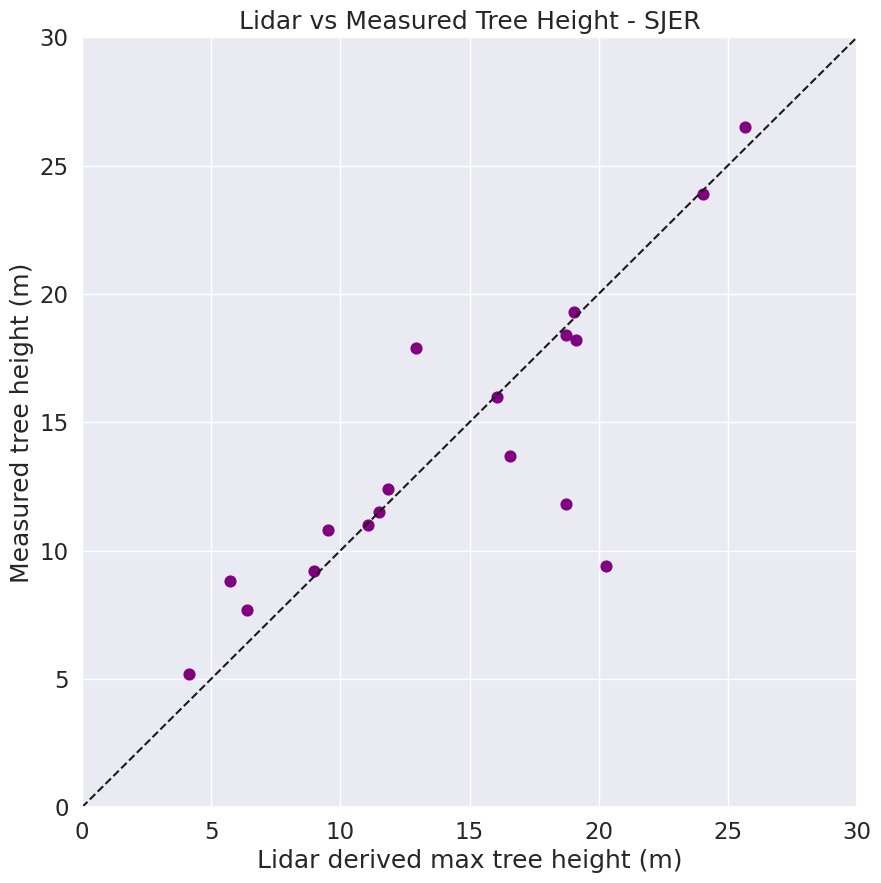

In [3]:
lidar_path = os.path.join("data", "spatial-vector-lidar",
                          "california",
                          "neon-sjer-site",
                          "2013",
                          "lidar",
                          "SJER_lidarCHM.tif")

sjer_chm_data = rxr.open_rasterio(lidar_path, masked=True).squeeze()

# Import plot locations and extract summary raster statistics
plot_buffer_path = os.path.join("data", "spatial-vector-lidar",
                                "outputs",
                                "plot_buffer.shp")

sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   sjer_chm_data.values,
                                   affine=sjer_chm_data.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   nodata=0,
                                   stats="mean max")

sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

# Import in situ data
path_insitu = os.path.join("data", "spatial-vector-lidar",
                           "california",
                           "neon-sjer-site",
                           "2013",
                           "insitu",
                           "veg_structure",
                           "D17_2013_SJER_vegStr.csv")

sjer_insitu = pd.read_csv(path_insitu)


# Get the max and mean stem height for each plot
insitu_stem_ht = sjer_insitu.groupby('plotid', as_index=False)
insitu_stem_ht = insitu_stem_ht['stemheight'].agg(['max', 'mean'])
insitu_stem_ht = insitu_stem_ht.rename(
    columns={'max': 'insitu_maxht', 'mean': 'insitu_meanht'})
insitu_stem_ht.reset_index(inplace=True)

# First rename columns so that we know which belongs to lidar
sjer_lidar_height_df = sjer_lidar_height_df.rename(
    columns={'max': 'lidar_max',
             'mean': 'lidar_mean',
             'min': 'lidar_min'})

# Join the data
sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                                               left_on='Plot_ID',
                                               right_on='plotid')
# Convert to a dataframe so we can use standard pandas plotting
sjer_final_height_df = pd.DataFrame(sjer_final_height)

# Plot scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

#csfont = {'fontname':'Myriad Pro'}
sjer_final_height_df.plot('lidar_max', 'insitu_maxht',
                          kind='scatter', color="purple",
                          s=60, ax=ax)

# Add a diagonal line
ax.set(xlim=[0, 30], ylim=[0, 30], label="Data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',
        c='k', label="1:1 line")

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height - SJER")

plt.show()

In practice, observations from different methods rarely show a 1:1 relationship. For example above, you can see how lidar estimates compare to human made measurements of tree height. Notice that some measurements are similar, and close to the 1:1 line. In other cases, when points lie above or below the 1:1 line, the measurements are different.

This all assumes that you decide that the human measurement is correct all of the time. But you know from discussions about uncertainty and from being a human yourself, that often times, humans make mistakes too! Some people may think that, particularly in dense forests, lidar does an even better job of measuring the tallest trees that humans can not fully get a clear view of to make a measurement.

A 1:1 line is a start at comparing two sets of measurements. However, what if you want to predict one measurement from another? For example, given a measurement of lidar derived tree height, what would be the measured tree height on the ground?

Linear regression is a way to predict one measurement from another. It accounts for the fact that the linear relationship between the two variables might not be a one to one line, and that there may be variation in the data around the line.

Linear regression requires two variables:

an independent variable - let’s call it x and
a dependent variable - let’s call it y
Linear regression uses x to predict y by finding the “best fit” line between x and y, assuming the following model:

$y=a+bx+error$
,where:

a
 is an intercept and
b
 is a slope
Conceptually “best fit” implies that the error term is minimized. One measure of fit is R-squared. When R2
 is close to one, the model fits well, and when R2
 is close to zero, the model fits poorly.

You can run a regression analysis on the data above using the stats package in scipy.

In [ ]:
x = sjer_final_height_df.lidar_max
y = sjer_final_height_df.insitu_maxht

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2)

Translating the Output
Intercept 2.98: Here our intercept is close to 3. This means that if the lidar derived height were 0, the estimated ground truth height would be close to 3, which may suggest some systematic offset between the lidar and ground measurements of height. But, we should be careful with this interpretation, because we did not have any lidar data with zero height measurements. Any conclusions we draw about such observations are extrapolations beyond the range of data that were observed.

Slope of .76: The slope is positive and while it’s not 1, it’s also not that far from 1 at .76. This is not terrible. This slope suggests that for a one meter increase in lidar derived height, we expect a 76 cm increase in ground truth height. This actually could make some sense if you think about how difficult it can be to measure tall trees manually. But how hard it might be for lidar systems to reflect off of shorter and potentially smaller trees

R squared of .69: This tells us that the linear regression model explains 69% of the variablility found in the data.

Overall with results like these we can conclude that lidar does a reasonable job of estimating tree height.

Plot Regression Fits Compared to 1:1
Look at a plot of the data below. You have both the 1:1 line and the regression model fit. Are they different? Think about what this output tells you.

In [ ]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

m = slope.astype(float)

sjer_final_height_df.plot('lidar_max',
                          'insitu_maxht',
                          kind='scatter',
                          color="purple",
                          s=60,
                          ax=ax,
                          label="Data")

# Add a diagonal line
ax.set(xlim=[0, 30], ylim=[0, 30])
ax.plot((0, 1), (0, 1), 'y-', transform=ax.transAxes, label="1:1 line")
ax.plot(x, m*x + intercept, 'grey', label='regression fitted line')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Tree Height - SJER")

plt.legend()
plt.show()

Good Fit, Large Intercept
Sometimes the question you are asking is whether one variable is the same (or similar to) another variable. In this case a model with a strong relationship, may still tell you that the two variables do not necessarily measure the same thing. For example, a model with a strong R-squared value may have a large intercept. In this case you know there is a significant bias where your predictor might under or overestimate the variable of interest:

Example: Lidar has a very strong fit with human measurements but the slope is very small and the intercept is very large. See below:

#### These are illustrative examples.

In [ ]:
# Create some points with a one to one relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item+10 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line')
ax.set(xlim=[0, 50], ylim=[0, 50])
ax.set(xlabel="Variable A",
       ylabel="Variable B",
       title="Data Points with a Strong \nR-squared and P-value but not a 1:1")

plt.legend(fontsize=14)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

Similarly maybe there is a positive bias in your predictor:

In [ ]:
# Create some points with a one to one relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line')

ax.set(xlim=[0, 50], ylim=[0, 50])
ax.set(xlabel="Variable A",
       ylabel="Variable B",
       title="Data Points with a Strong \nR-squared but There is a Positive Bias")
plt.legend()

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

Other Linear Regression Model Outputs
The ouputs of a linear regression model help you assess how statistically useful or significant the model is as compared to a hypothesis or theory that there is no relationship between the variables. If the data have no relationship, then the slope of the line is 0. In scientific terms this translates to whether you want to trust the model or not. These outputs includes:

Root Mean Squared Error (RMSE): RMSE is an overall measure of how far the y-values lie from the estimated line on average. You can think of it as on average, how far away from a 1:1 relationship are the predicted data. If lidar is predicting human measurements is it on average 1m taller, 2m shorter, etc? Technically defined, it’s defined as the square root of the variance of the residuals.
##### I think the above is wrong, it is not how far from a 1:1 relatiobsbip the predicted data are. It is how far the real data is from the predicted data (a line in the case of a linear regression)

P-value: The p-value can be used to see how consistent the data are with the notion that the true slope of the line is zero (that there is no relationship between the variables of interest). A threshold of 0.05 is commonly used to determine whether there is sufficient evidence to reject the hypothesis that the true slope is zero. If p < 0.05, then one typically concludes the true slope is nonzero, though this threshold is arbitrary.

Note that to calculate the RMSE you take the squareroot of the standard error provided to you by Python.

In [ ]:
# Create some points with a one to one relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line',
        color="purple")
ax.set(xlim=[0, 50], ylim=[0, 50])

ax.set(xlabel="Variable A",
       ylabel="Variable B",
       title="Data Points with a Strong \nR-squared but There is a Positive Bias")

plt.legend()

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

Use Seaborn To Plot Regression Fit
Below is a plot of the same data using the seaborn package. The Seaborn package wraps around Matplotlib. It makes it easier to make nice looking plots, quickly.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.regplot('lidar_max', 'insitu_maxht', data=sjer_final_height_df,
                 color="purple")

# Add a diagonal line
ax.set(xlim=[5, 30], ylim=[5, 30])
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--', c='k')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Tree Height - SJER")

plt.show()

View Difference: Lidar vs. Measured
A non statistical approach to understand the relationship between these two variables is a plain old difference plot. Below you can identify which ground plots have the largest difference and which ones have the smallest. If you were working with these data, you might want to explore each individual plot to see if you can figure out why this relationship works better in some plots compared to others.

Below is the code for the challenege opportunity in the last lesson.

Can you think of any things that could occur in particular plots that may through off your data?

In [ ]:
# Calculate difference and add the plot id to each xaxis label
sjer_final_height["lidar_measured"] = sjer_final_height["lidar_max"] - \
    sjer_final_height["insitu_maxht"]

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(sjer_final_height['plotid'],
       sjer_final_height['lidar_measured'],
       color="purple")

ax.set(xlabel='Plot ID',
       ylabel='(Lidar - Measured) Height Difference (m)',
       title='Difference Between lidar and Measured Tree Height')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()